In [1]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
ticker = 'TSLA'
df = yf.download(ticker, '2020-01-01')

C:\Users\Dawit\AppData\Local\Temp\ipykernel_1376\2748477947.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500
...,...,...,...,...,...
2025-08-25,346.600006,349.529999,335.029999,338.899994,86670000
2025-08-26,351.670013,351.899994,343.720001,344.929993,76651600


<Axes: xlabel='Date'>

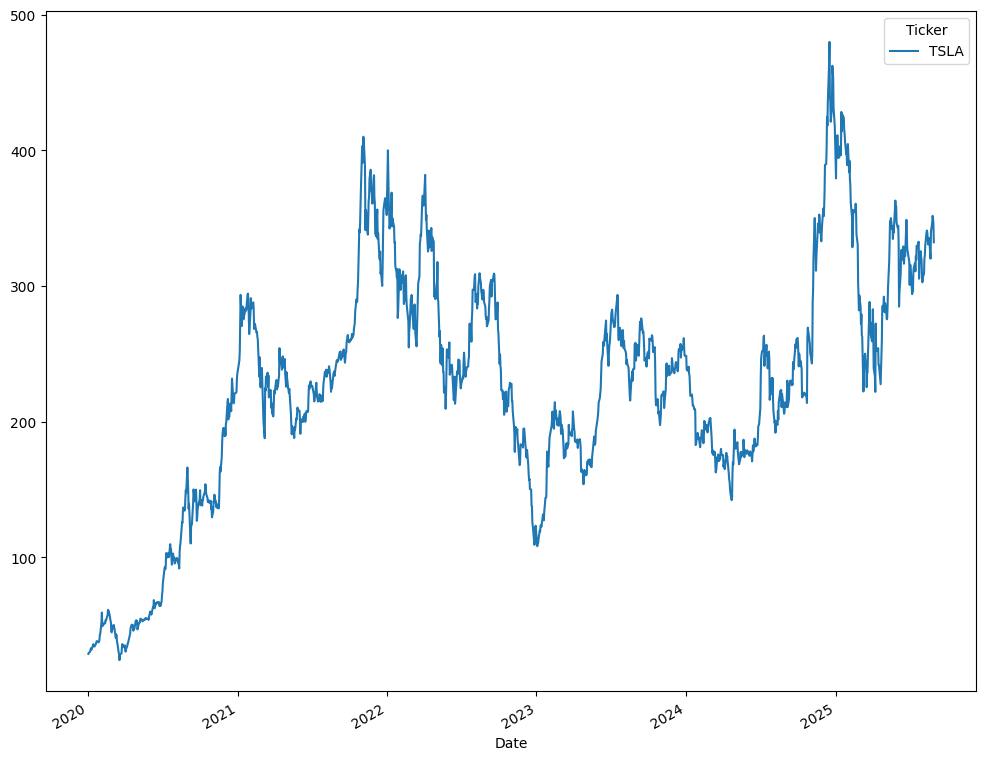

In [5]:
df.Close.plot(figsize=(12, 10))

In [6]:
scaler = StandardScaler()
df["Close"] = scaler.fit_transform(df['Close'])
df.Close

Ticker,TSLA
Date,
2020-01-02,-2.264337
2020-01-03,-2.254564
2020-01-06,-2.248025
2020-01-07,-2.234595
2020-01-08,-2.216904
...,...
2025-08-25,1.391062
2025-08-26,1.449357
2025-08-27,1.425556


In [7]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])
data = np.array(data)


In [8]:
data

array([[[-2.26433699],
        [-2.25456368],
        [-2.24802515],
        ...,
        [-2.00055747],
        [-2.00599216],
        [-1.97785275]],

       [[-2.25456368],
        [-2.24802515],
        [-2.23459549],
        ...,
        [-2.00599216],
        [-1.97785275],
        [-1.98089585]],

       [[-2.24802515],
        [-2.23459549],
        [-2.21690389],
        ...,
        [-1.97785275],
        [-1.98089585],
        [-1.93615332]],

       ...,

       [[ 1.10441727],
        [ 1.07843167],
        [ 1.19617111],
        ...,
        [ 1.31529061],
        [ 1.39106242],
        [ 1.44935738]],

       [[ 1.07843167],
        [ 1.19617111],
        [ 1.18283339],
        ...,
        [ 1.39106242],
        [ 1.44935738],
        [ 1.42555643]],

       [[ 1.19617111],
        [ 1.18283339],
        [ 1.2244561 ],
        ...,
        [ 1.44935738],
        [ 1.42555643],
        [ 1.38393371]]], shape=(1393, 30, 1))

In [9]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)


In [10]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out
    

In [11]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.8054521083831787
25 0.033001646399497986
50 0.01501888781785965
75 0.012394921854138374
100 0.011265737004578114
125 0.010372329503297806
150 0.009735564701259136
175 0.009406833909451962


In [14]:
model.eval()
y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())



In [15]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])


In [16]:
train_rmse

8.381415367126465

In [17]:
test_rmse

14.155673027038574

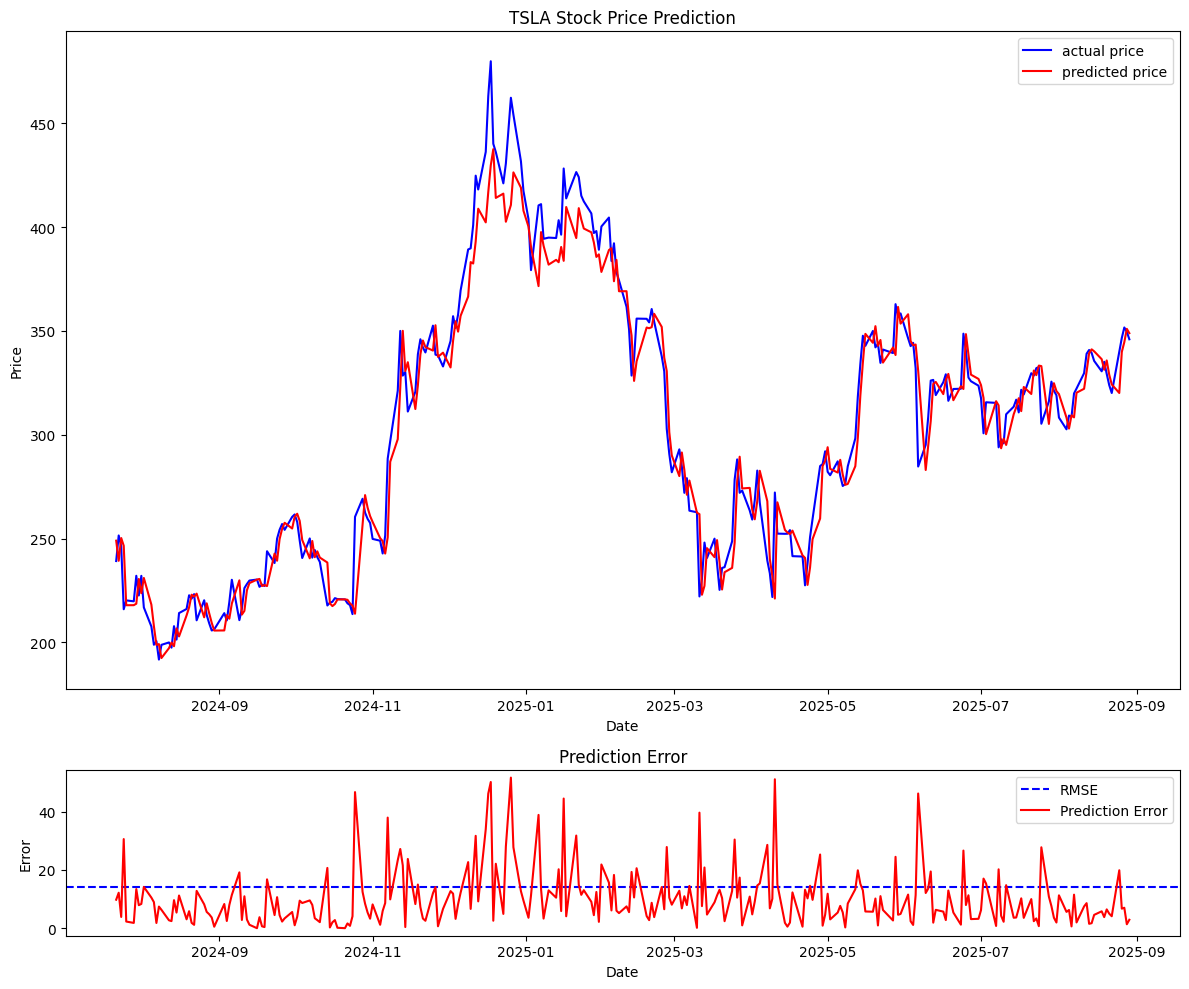

In [18]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

axl = fig.add_subplot(gs[:3, 0])
axl.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'actual price')
axl.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'red', label = 'predicted price')

axl.legend()

plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()